In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

import joblib

import lightgbm as lgb

from tqdm import tqdm_notebook
import scipy.optimize as spo

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import FunctionTransformer

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

In [2]:
def run_lgbm(X_train, X_test, y_train, y_test, feature_names, categorical_features='auto', model_params=None, fit_params=None, seed=21):

    X_train_GBM = lgb.Dataset(X_train, label=y_train, feature_name=feature_names, categorical_feature=categorical_features, free_raw_data=False)
    X_test_GBM = lgb.Dataset(X_test, label=y_test, reference=X_train_GBM, feature_name=feature_names, free_raw_data=False)
    
    if model_params is None:
        model_params = {'seed': seed, 'num_threads': 16, 'objective':'root_mean_squared_error', 
                        'metric': ['root_mean_squared_error'] }
        
    if fit_params is None:
        fit_params = {'verbose_eval': True, 'num_boost_round': 300, 'valid_sets': [X_test_GBM], 
                      'early_stopping_rounds': 30, 'categorical_feature': categorical_features, 'feature_name': feature_names}
        
    model = lgb.train(model_params, X_train_GBM, **fit_params)
    y_pred = model.predict(X_test, model.best_iteration)
    return model, y_pred, mean_squared_error(y_test, y_pred)

## Lgbm

In [3]:
df_train_dataset = pd.read_pickle('data/df/df_train_dataset.pkl')
df_validation_dataset = pd.read_pickle('data/df/df_validation_dataset.pkl')

In [4]:
continuous_features = joblib.load('data/iterables/continuous_features.joblib')
categorical_features = joblib.load('data/iterables/categorical_features.joblib')
target_features = joblib.load('data/iterables/target_features.joblib')
target_transformer = joblib.load('models/preprocessing/target_transformer.joblib')

In [5]:
df_train_dataset.shape, df_validation_dataset.shape

((338192, 122), (146765, 122))

In [6]:
X = df_train_dataset[categorical_features + continuous_features].values
y = df_train_dataset[target_features].values.flatten()
print(X.shape, y.shape)

(338192, 119) (338192,)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85, test_size=0.15, shuffle=True, random_state=10)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(287463, 119) (50729, 119) (287463,) (50729,)


In [8]:
feature_names = categorical_features + continuous_features
X_train_GBM = lgb.Dataset(X_train, label=y_train, feature_name=feature_names, categorical_feature=categorical_features, free_raw_data=False)
X_test_GBM = lgb.Dataset(X_test, label=y_test, reference=X_train_GBM, feature_name=feature_names, free_raw_data=False)

In [15]:
"""
'learning_rate': hp.uniform('learning_rate', 0.001, 0.04),
'max_depth' : hp.quniform("max_depth", 3, 8, 1),
'bagging_fraction': hp.uniform('bagging_fraction', 0.85, 1.0),  
'bagging_freq': hp.quniform('bagging_freq', 1, 16, 1),
'lambda_l1': hp.uniform('lambda_l1', 4.0, 16.0), 
'lambda_l2': hp.uniform('lambda_l2', 4.0, 16.0),
'feature_fraction': hp.uniform('feature_fraction', 0.10, 0.30),
'num_leaves': hp.quniform("num_leaves", 4, 64, 1),
'min_data_in_leaf': hp.quniform("min_data_in_leaf", 32, 512, 1),
'max_delta_step': hp.uniform('max_delta_step', 0.0, 0.5),
'min_data_per_group': hp.quniform('min_data_per_group', 16, 512, 1),
'min_sum_hessian_in_leaf' : hp.uniform('min_sum_hessian_in_leaf', 0.5, 4.0),
'min_gain_to_split': hp.uniform('min_gain_to_split', 0.0, 1.0),
'max_bin' : hp.quniform("max_bin", 64, 512, 1),
'min_data_in_bin': hp.quniform("min_data_in_bin", 1, 32, 1),
'max_cat_threshold': hp.quniform('max_cat_threshold', 16, 64, 1),
'cat_l2' : hp.uniform('cat_l2', 32.0, 64.0),
'cat_smooth': hp.uniform('cat_smooth', 0.0, 4.0),
'sparse_threshold' : hp.uniform('sparse_threshold', 0.16, 0.64),
'boost_from_average': hp.choice('boost_from_average', [True, False]),

"""
space = {
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.04),
    'max_depth' : hp.quniform("max_depth", 3, 8, 1),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.85, 1.0),  
    'bagging_freq': hp.quniform('bagging_freq', 1, 16, 1),
    'lambda_l1': hp.uniform('lambda_l1', 4.0, 16.0), 
    'lambda_l2': hp.uniform('lambda_l2', 4.0, 16.0),
    'feature_fraction': hp.uniform('feature_fraction', 0.10, 0.30),
    'num_leaves': hp.quniform("num_leaves", 4, 64, 1),
    'min_data_in_leaf': hp.quniform("min_data_in_leaf", 32, 512, 1),
    'max_delta_step': hp.uniform('max_delta_step', 0.0, 0.5),
    'min_data_per_group': hp.quniform('min_data_per_group', 16, 512, 1),
    'min_sum_hessian_in_leaf' : hp.uniform('min_sum_hessian_in_leaf', 0.5, 4.0),
    'min_gain_to_split': hp.uniform('min_gain_to_split', 0.0, 1.0),
    'max_bin' : hp.quniform("max_bin", 64, 512, 1),
    'min_data_in_bin': hp.quniform("min_data_in_bin", 1, 32, 1),
    'max_cat_threshold': hp.quniform('max_cat_threshold', 16, 64, 1),
    'cat_l2' : hp.uniform('cat_l2', 32.0, 128.0),
    'cat_smooth': hp.uniform('cat_smooth', 0.0, 4.0),
    'sparse_threshold' : hp.uniform('sparse_threshold', 0.16, 0.64),

}

In [16]:
param_ints = ['max_depth', 'bagging_freq', 'num_leaves', 'min_data_in_leaf', 'min_data_per_group', 'max_bin', 
              'min_data_in_bin', 'max_cat_threshold']
def objective(space):
    model_params = {'num_threads': 16, 'objective': 'root_mean_squared_error', 
                    'metric': ['root_mean_squared_error'], 'boosting': 'gbdt'}
    
    for param in space.keys():
        if param in param_ints:
            model_params[param] = int(space[param])
        else:
            model_params[param] = space[param]
        
    fit_params = {'verbose_eval': False, 'num_boost_round': 300, 'valid_sets': [X_test_GBM], 'early_stopping_rounds': 30, 
                 'categorical_feature': categorical_features, 'feature_name': feature_names}
    
    model = lgb.train(model_params, X_train_GBM, **fit_params)  
    y_pred = model.predict(X_test, model.best_iteration)
    
    results = {'loss': mean_squared_error(y_test, y_pred) ** .5, 'status': STATUS_OK }
    for param in space.keys():
        results[param] = space[param]
    return results

In [17]:
trials = Trials()
best_parameters = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

100%|██████████| 100/100 [12:32<00:00,  7.85s/it, best loss: 0.12259643964754367]


In [18]:
print(best_parameters)
joblib.dump(best_parameters, 'models/parameters/best_parameters2.joblib')

{'bagging_fraction': 0.9830356259765703, 'bagging_freq': 9.0, 'cat_l2': 51.40240661408538, 'cat_smooth': 1.8494002054243066, 'feature_fraction': 0.28058304241318754, 'lambda_l1': 5.388803595258235, 'lambda_l2': 6.868490946655484, 'learning_rate': 0.03578751542869848, 'max_bin': 466.0, 'max_cat_threshold': 39.0, 'max_delta_step': 0.27948550018035967, 'max_depth': 6.0, 'min_data_in_bin': 17.0, 'min_data_in_leaf': 114.0, 'min_data_per_group': 404.0, 'min_gain_to_split': 0.1503709410019914, 'min_sum_hessian_in_leaf': 2.4672279431394806, 'num_leaves': 60.0, 'sparse_threshold': 0.380260196469647}


['models/parameters/best_parameters2.joblib']

In [99]:
df = pd.DataFrame(trials.results)
df.nsmallest(10, 'loss')

,bagging_fraction,bagging_freq,boost_from_average,cat_l2,cat_smooth,feature_fraction,lambda_l1,lambda_l2,learning_rate,loss,...,max_delta_step,max_depth,min_data_in_bin,min_data_in_leaf,min_data_per_group,min_gain_to_split,min_sum_hessian_in_leaf,num_leaves,sparse_threshold,status
24,0.956319,14.0,True,36.285375,3.968228,0.269915,4.430941,6.032881,0.036590,0.122365,...,0.286282,7.0,24.0,94.0,208.0,0.014238,2.515303,28.0,0.161188,ok
25,0.958898,14.0,True,37.338306,3.996000,0.292562,7.711478,5.420360,0.036600,0.122481,...,0.467735,7.0,24.0,90.0,194.0,0.001816,2.370192,25.0,0.168208,ok
21,0.951783,16.0,True,32.003918,3.901894,0.257474,6.889187,4.347178,0.039883,0.122528,...,0.298635,7.0,22.0,41.0,225.0,0.011982,2.619818,55.0,0.160935,ok
36,0.980093,15.0,True,46.469673,3.618718,0.248205,7.333754,6.166060,0.030026,0.122665,...,0.266047,8.0,5.0,155.0,94.0,0.188792,2.006417,20.0,0.259151,ok
26,0.986926,14.0,True,37.807435,3.921964,0.296010,10.281893,5.730291,0.036440,0.122711,...,0.474006,6.0,25.0,90.0,147.0,0.071248,1.493297,24.0,0.195474,ok
27,0.960908,14.0,True,39.313736,2.272155,0.274706,5.308877,5.370593,0.027804,0.122714,...,0.464237,7.0,19.0,89.0,201.0,0.376217,2.336389,31.0,0.160385,ok
23,0.945661,14.0,True,32.462766,3.354127,0.265939,4.219128,4.175170,0.035380,0.122794,...,0.288622,7.0,21.0,33.0,237.0,0.004057,2.526733,30.0,0.289372,ok
32,0.987880,15.0,True,42.549699,3.241866,0.292939,5.142206,6.418653,0.038030,0.122847,...,0.350890,6.0,20.0,78.0,120.0,0.530299,2.273805,32.0,0.235947,ok
38,0.936067,9.0,True,37.050666,3.979062,0.208930,5.939065,6.916768,0.039314,0.122855,...,0.394417,6.0,11.0,324.0,164.0,0.058089,3.412803,40.0,0.203741,ok
47,0.971596,1.0,True,59.154366,2.516636,0.285642,7.283007,15.849539,0.026032,0.123000,...,0.434820,8.0,16.0,62.0,102.0,0.291578,2.072692,13.0,0.351678,ok


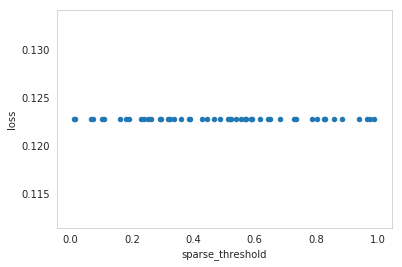

In [90]:
df.plot(x='sparse_threshold', y='loss', kind='scatter');

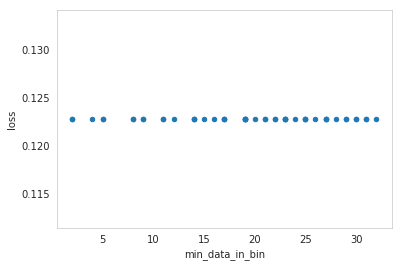

In [73]:
df.plot(x='min_data_in_bin', y='loss', kind='scatter');